# Module 1 - Introduction to MLOps

**What is MLOps?** There is no exact definition for MLOps. In generally, it means putting Machine Learning models in production.<br>

**What will we learn?** Deployment, monitoring, web services, Data drift

**What tools will we use?** MLflow, AWS Lambda, Docker, Git, Kubeflow, Kinesis/SQS

**How much time do I have to devote daily or weekly?** Not known. Approx. 8 - 10 h. Need to be tracked.

## 1.2 Environment preparation
The zoomcamp chose AWS as environment. 

I decided to first use a local environment and then use GCP instead.


## 1.3 Training a ride duration prediction model

Our problem:

We want to develop a model that can predict the duration of a taxi trip from point A to B.

For that, we 
1. preprocess data
2. design a regression model
3. train a model

Data:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

* Green Taxi Trip Records (PARQUET) January 2021: 'green_tripdata_2021-01.parquet'
* Green Taxi Trip Records (PARQUET) February 2021: 'green_tripdata_2021-02.parquet'


### Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

import pyarrow  # read .parquet files
import pickle

### Reading Parquet files

Parquet file require less memory than .csv files.

In [35]:
# Read the .parquet file with pandas
df = pd.read_parquet(r"C:\Users\JC\projects\MLOps_Zoomcamp_2022\data\green_tripdata_2021-01.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [3]:
# How big is the dataframe?
len(df)

76518

In [4]:
# Check the data types of each column
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

### Select data for the regression model

We are only interested in the data we need for the prediction of the ride duration. Hence, we filter for 

* **trip_type** (1: street-hail, 2: Dispatch): to reduce the amount of data, we just select "Dispatch"
* *TARGET VARIABLE* **trip_duration**: to calculate the trip duration, we substract lpep_pickup_datetime from lpep_dropoff_datetime and save it as trip_duration. However, we have to cast to the duration from the datetime64 dtype into a variable, that can be used for the regression model. So it will be converted to minutes

In [5]:
# Filter the data on the selected criteria
df = df[df.trip_type==2]

# New variable tripduration
df["trip_duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

# Convert the trip_duration into minutes
df.trip_duration = df.trip_duration.apply(lambda x: x.total_seconds() / 60)

# Check the new dataframe
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5.0,265,265,1.0,0.00,180.0,...,0.0,36.06,0.0,None,0.3,216.36,1.0,2.0,0.0,0.116667
15,2,2021-01-01 00:29:05,2021-01-01 00:29:07,N,5.0,42,264,1.0,0.00,10.0,...,0.0,2.06,0.0,None,0.3,12.36,1.0,2.0,0.0,0.033333
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.00,0.0,None,0.3,13.30,2.0,2.0,0.0,19.766667
43,2,2021-01-01 23:12:41,2021-01-02 01:13:53,N,5.0,95,82,1.0,0.00,9.7,...,0.0,2.00,0.0,None,0.3,12.00,1.0,2.0,0.0,121.200000
45,2,2021-01-01 01:49:29,2021-01-01 01:49:33,N,5.0,244,244,5.0,0.02,12.0,...,0.0,2.46,0.0,None,0.3,14.76,1.0,2.0,0.0,0.066667


### Distribution of the target variable (*trip_duration*)

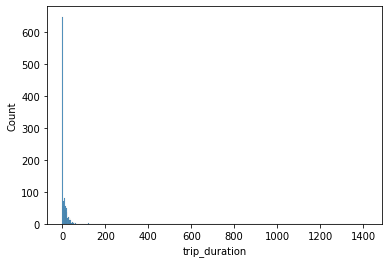

In [6]:
# Distribution of the target variable "trip_duration"
sns.histplot(df.trip_duration);

In [7]:
# Check description of the target variable
df.trip_duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: trip_duration, dtype: float64

#### Findings:
The trip duration has a long tail to right (right-skewed distribution). 98 % trips take less than 1 h. From a business point of view, it is advisable to focus on trips within 1 to 60 min duration.

In [8]:
# Extra filter on trip duration from 1 min up to 60 min and check how many are in this interval
((df.trip_duration >= 1) & (df.trip_duration <= 60)).mean()

0.5169628432956381

Only 50 % of all values fall into the this range. Many values must be below 1 min.

In [9]:
(df.trip_duration <= 1).mean()

0.462843295638126

YES! Many values lie below 1 min. So... We remove the *trip_type* filter from the dataframe.

In [10]:
# Refresh the .parquet file
df = pd.read_parquet(r"C:\Users\JC\projects\MLOps_Zoomcamp_2022\data\green_tripdata_2021-01.parquet")

# Create the target variable
df["trip_duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.trip_duration = df.trip_duration.apply(lambda x: x.total_seconds() / 60)

# Extra filter on trip duration from 1 min up to 60 min
df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [11]:
# Preprocess the target variable for the prediction model
y = df["trip_duration"].values

### Feature preproccessing
WE are selecting variables that have an influence on the target variable and use them to predict the trip duration.

* Define the categorical features: pick up and drop-off location and OneHot encode them
* Define numerical variables: trip_distance (in miles)


In [12]:
# Create categorical variables
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [13]:
# CHeck the dtypes of the features
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

For OneHot encoding, we need to convert the categorical variables to strings. 

In [14]:
# Convert to string (object)
df[categorical] = df[categorical].astype(str)
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

We use the DictVectorizer from scikit-learn to turn a dictionary into a vector. The features are converted into a dictionary

In [15]:
# Convert features to dictionary
train_dicts = df[categorical + numerical].to_dict(orient="records")

# Create a DictVectorizer
dv = DictVectorizer()

# Fit to the feature dict and save it in a feature matrix
X = dv.fit_transform(train_dicts)
X

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [16]:
# Check the feature names
dv.feature_names_[:10]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11']

### Baseline model

We do not split the data into train and test set at this time point.

In [17]:
# Create a model
lr = LinearRegression()
lr.fit(X, y)

# Make a prediction
y_pred = lr.predict(X)

### Evaluation of the baseline model

In [18]:
# Calculate the RMSE
mean_squared_error(y, y_pred, squared=False)

9.838799799886802

Our model is wrong around 9 min in average, which is not good.

c:\Users\JC\projects\MLOps_Zoomcamp_2022\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\JC\projects\MLOps_Zoomcamp_2022\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


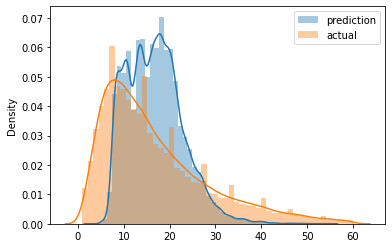

In [19]:
# Visualize the true and predicted values
sns.distplot(y_pred, label="prediction")
sns.distplot(y, label="actual")
plt.legend();

### Validation
For validation we use the Febuary 2021 dataset

In [20]:
# Functionize the read and processing of the dataframe
def read_df(path):
    # Read the .parquet file
    df = pd.read_parquet(path)

    # Create the target variable
    df["trip_duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.trip_duration = df.trip_duration.apply(lambda x: x.total_seconds() / 60)

    # Extra filter on trip duration from 1 min up to 60 min
    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]
    
    return df

In [21]:
# Function for preprocessing the features (X)
def create_dicts(df,categorical, numerical):
    # Convert to string (object)
    df[categorical] = df[categorical].astype(str)
    
    # Convert features to dictionary
    dicts = df[categorical + numerical].to_dict(orient="records")

    return dicts

In [22]:
# Create a dataframe for the February dataset
df_train = read_df(r"C:\Users\JC\projects\MLOps_Zoomcamp_2022\data\green_tripdata_2021-01.parquet")

# Create a dataframe for the February dataset
df_val = read_df(r"C:\Users\JC\projects\MLOps_Zoomcamp_2022\data\green_tripdata_2021-02.parquet")

In [23]:
# Create categorical variables
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]


# Create a DictVectorizer
dv = DictVectorizer()

# Fit to the feature dict and save it in a feature matrix
X_train_dicts = create_dicts(df_train, categorical, numerical)
X_train = dv.fit_transform(X_train_dicts)
y_train = df_train["trip_duration"].values

# Create X and y from the validation dataset (Feb 2021)
X_val_dicts = create_dicts(df_val, categorical, numerical)
X_val = dv.transform(X_val_dicts)
y_val = df_val["trip_duration"].values  
    

In [24]:
X_train, len(y_train)

(<73908x507 sparse matrix of type '<class 'numpy.float64'>'
 	with 221724 stored elements in Compressed Sparse Row format>,
 73908)

In [25]:
X_val, len(y_val)

(<61921x507 sparse matrix of type '<class 'numpy.float64'>'
 	with 185758 stored elements in Compressed Sparse Row format>,
 61921)

In [26]:
# Train a regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate the baseline with the validation dataset
y_pred_val = lr.predict(X_val)
mean_squared_error(y_val, y_pred_val, squared=False)

10.499110706512404

## Improve the model

To improve our baseline model, we use Lasso as Linear Model with L1 as regularizer (aka the Lasso).

In [27]:
# Linear Lasso model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

for i in alphas:
    lr = Lasso(alpha=i)
    lr.fit(X_train, y_train)

    # Evaluate the RMSE
    y_pred_val = lr.predict(X_val)
    print(f"For alpha = {i} the RMSE is: {mean_squared_error(y_val, y_pred_val, squared=False)}")

For alpha = 0.0001 the RMSE is: 10.47054920225702
For alpha = 0.001 the RMSE is: 10.481255832596219
For alpha = 0.01 the RMSE is: 10.812725703916977
For alpha = 0.1 the RMSE is: 11.674811916671658
For alpha = 1 the RMSE is: 12.212583224318818


In [28]:
# Linear Ridge model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

for i in alphas:
    lr = Ridge(alpha=i)
    lr.fit(X_train, y_train)

    # Evaluate the RMSE
    y_pred_val = lr.predict(X_val)
    print(f"For alpha = {i} the RMSE is: {mean_squared_error(y_val, y_pred_val, squared=False)}")

For alpha = 0.0001 the RMSE is: 10.860698344729776
For alpha = 0.001 the RMSE is: 10.860698393256552
For alpha = 0.01 the RMSE is: 10.860698878827817
For alpha = 0.1 the RMSE is: 10.860703744451401
For alpha = 1 the RMSE is: 10.860753390357996


Ridge and Lasso do not improve the baseline model. Let´s try to improve the model by changing the features.

### Feature Engineering
Pick-up and drop-off location were used as seperate features, but in reality they depend on each other. WE create an interaction feature, that means pick-up and drop-off location are melted together in one feature.

In [29]:
# Create a new interaction feature
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [30]:
# Create categorical variables
categorical = ["PU_DO"]
numerical = ["trip_distance"]


# Create a DictVectorizer
dv = DictVectorizer()

# Fit to the feature dict and save it in a feature matrix
X_train_dicts = create_dicts(df_train, categorical, numerical)
X_train = dv.fit_transform(X_train_dicts)
y_train = df_train["trip_duration"].values

# Create X and y from the validation dataset (Feb 2021)
X_val_dicts = create_dicts(df_val, categorical, numerical)
X_val = dv.transform(X_val_dicts)
y_val = df_val["trip_duration"].values

In [31]:
# Train a regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate the baseline with the validation dataset
y_pred= lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.7587151974993125

In [32]:
# Linear Lasso model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

for i in alphas:
    lr = Lasso(alpha=i)
    lr.fit(X_train, y_train)

    # Evaluate the RMSE
    y_pred_val = lr.predict(X_val)
    print(f"For alpha = {i} the RMSE is: {mean_squared_error(y_val, y_pred_val, squared=False)}")

For alpha = 0.0001 the RMSE is: 7.616617761096093
For alpha = 0.001 the RMSE is: 9.233436225720547
For alpha = 0.01 the RMSE is: 11.167275941179728
For alpha = 0.1 the RMSE is: 12.143233939663894
For alpha = 1 the RMSE is: 12.212583224318818


In [33]:
# Linear Ridge model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

for i in alphas:
    lr = Ridge(alpha=i)
    lr.fit(X_train, y_train)

    # Evaluate the RMSE
    y_pred_val = lr.predict(X_val)
    print(f"For alpha = {i} the RMSE is: {mean_squared_error(y_val, y_pred_val, squared=False)}")

For alpha = 0.0001 the RMSE is: 11.342565573447871
For alpha = 0.001 the RMSE is: 11.342565604853801
For alpha = 0.01 the RMSE is: 11.342565919224548
For alpha = 0.1 the RMSE is: 11.342569094065542
For alpha = 1 the RMSE is: 11.34260394325033


### Save the best model
The best model so far, is the linear regression model. We will save the model for later use in a pickle file

In [34]:
# Save the model
with open(r"C:\Users\JC\projects\MLOps_Zoomcamp_2022\models\lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)